In [1]:
import math, random

import gym
import numpy as np
from collections import namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
'''
Use namedtuple to construct the ReplayMemory
'''

Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayMemory(object):
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        # Push need 4 arguments, includes state, action, next_state and reward.
        if len(self.memory) < self.capacity:
            self.memory.append(None)  # defalut value, 
        self.memory[self.position] = Transition(*args) # Replace the default value or the original value
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
env = gym.make("CartPole-v0")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [5]:
class Parser():
    def __init__(self,):
        self.BATCH_SIZE = 128
        self.GAMMA = 0.999
        self.EPS_START = 0.9
        self.EPS_END = 0.05
        self.EPS_DECAY = 200
        self.TARGET_UPDATE = 10
        
args = Parser()

In [6]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.num_inputs = num_inputs
        self.num_actions = num_actions
        self.steps_done =0 
        
        self.layers = nn.Sequential(
            nn.Linear(self.num_inputs, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, self.num_actions)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state):
        self.eps_threshold = args.EPS_END + (args.EPS_START - args.EPS_END) *\
                        math.exp(-1. * self.steps_done / args.EPS_DECAY)
        if random.random() > self.eps_threshold:
            q_value = self.layers(state)
            self.Q = q_value
            action  = q_value.max(1)[1][0] # output the action has the highest q_value
        else:
            action = torch.tensor(random.randrange(self.num_actions))
        self.steps_done += 1
        return action

In [7]:
def compute_td_loss():
    
    transitions = replay_buffer.sample(args.BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    
    state_batch = torch.FloatTensor(batch.state)
    action_batch = torch.LongTensor(batch.action)
    reward_batch = torch.FloatTensor(batch.reward)
    next_state_batch = torch.FloatTensor(batch.next_state)
    done_batch = torch.FloatTensor(batch.done)
    

    q_values = dqn(state_batch).gather(1,action_batch.unsqueeze(1)).squeeze()
    
    
    next_q_values = t_dqn(next_state_batch).max(1)[0].detach()

    expected_q_values = reward_batch + (next_q_values * args.GAMMA) * (1-done_batch)  # Similar to the critic loss

    loss = F.mse_loss(q_values, expected_q_values)    
#     loss = (q_values - expected_q_values).pow(2).mean()    
    optimizer.zero_grad()
    loss.backward()
    for param in dqn.parameters(): 
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    
    return loss

In [8]:
def plot(frame_idxframe_id , rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

In [9]:
dqn = DQN(env.observation_space.shape[0],env.action_space.n)
t_dqn = DQN(env.observation_space.shape[0],env.action_space.n)
optimizer = optim.Adam(dqn.parameters())
replay_buffer = ReplayMemory(1000)

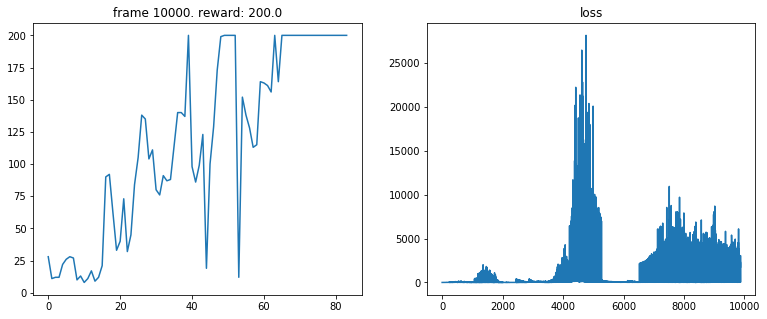

In [10]:
num_frames = 10000

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    action = dqn.act(torch.FloatTensor(state).unsqueeze(0)).item()
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > args.BATCH_SIZE:
        loss = compute_td_loss()
        losses.append(loss.item())
        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)
        
    if frame_idx % args.TARGET_UPDATE == 0:
        t_dqn.load_state_dict(dqn.state_dict())